In [107]:
!pip install xgboost

# Give yourself access to common
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
    
# Setup autoreload
%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
import numpy as np
import pandas as pd
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import common
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [109]:
def run_xg_boost(X_train, X_test, y_train, y_test):
    xgb_r = xg.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=500, objective='reg:squarederror')
  
    # Fitting the model
    xgb_r.fit(X_train, y_train)
    
    # Predict the model
    y_pred = xgb_r.predict(X_test)


    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2_s=r2_score(y_test, y_pred)
    print("MSE: ",mse)
    print("r2_socre: ",r2_s)
    print("RMSE: ",rmse)
    print("MAE:",mae)
    
    return xgb_r

In [110]:
def run_randomized_xg_boost(X_train, X_test, y_train, y_test):
    params = {
        'n_estimators':[500],
        'min_child_weight':[4,5], 
        'gamma':[i/10.0 for i in range(3,6)],  
        'subsample':[i/10.0 for i in range(6,11)],
        'colsample_bytree':[i/10.0 for i in range(6,11)], 
        'max_depth': [2,3,4,6,7],
        'objective': ['reg:squarederror', 'reg:tweedie'],
        'booster': ['gbtree', 'gblinear'],
        'eval_metric': ['rmse'],
        'eta': [i/10.0 for i in range(3,6)],
    }

    # xgbr = xg.XGBRegressor(objective='reg:squarederror', booster='gbtree', seed = 20)
    
    
    xgbr = xg.XGBRegressor(nthread=-1)
    clf = RandomizedSearchCV(estimator = xgbr, 
                            param_distributions=params,
                            n_iter=100, 
                            cv=3, 
                            scoring='neg_mean_squared_error',
                            verbose=2, 
                            random_state=42, 
                            n_jobs = -1)
    clf.fit(X_train, y_train)
    # print("Detailed results: ",clf.cv_results_)
    # xgb_r = xg.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=500, objective='reg:squarederror', booster='gbtree')
    
    # # Fitting the model
    # xgb_r.fit(X_train, y_train)
    best_random = clf.best_estimator_
    y_pred = best_random.predict(X_test)
    # # Predict the model
    # pred = xgb_r.predict(X_test)
    
    # # RMSE Computation
    # rmse = np.sqrt(mean_squared_error(y_test, pred))
    # print("RMSE : % f" %(rmse))

    # MSE = mean_squared_error(y_test, pred)
    # r2 = r2_score(y_test, pred)

    # print(f"MSE: {MSE}, R2: {r2}")
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2_s=r2_score(y_test, y_pred)
    print("Best parameters:", clf.best_params_)
    print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))
    print("Training MSE:", -clf.best_score_)
    
    print("MSE: ",mse)
    print("r2_socre: ",r2_s)
    print("RMSE: ",rmse)
    print("MAE:",mae)
    
    return best_random

In [111]:
def visualize_features(nba_dataset, model):
    Predictors=nba_dataset.columns[1:-1]
    feature_importances = pd.Series(model.feature_importances_, index=Predictors)
    feature_importances.plot(kind='barh')

# BASELINE DATA

In [112]:
# nba = common.get_cleaned_baseline_data('./data/cleaned_data/base_cleaned.csv')
nba = common.get_cleaned_baseline_data()

nba = common.add_log_y_values(nba)

In [113]:
X_train, X_test, y_train, y_test = common.split_data(nba)

In [114]:
# Without hyperparameter tuning
xgb_r = run_xg_boost(X_train, X_test, y_train, y_test)

MSE:  0.8447541218434187
r2_socre:  0.46518626175815037
RMSE:  0.9191050657261218
MAE: 0.6871020396203079


In [115]:
# With hyperparameter tuning
best_random = run_randomized_xg_boost(X_train, X_test, y_train, y_test)



Fitting 3 folds for each of 100 candidates, totalling 300 fits
[14:59:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[14:59:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[14:59:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[CV] END booster=gblinear, colsample_bytree=0.9, eta=0.5, eval_metric=rmse, gamma=0.4, max_depth=4, min_child_weight=4, n_estimators=500, objective=reg:squarederror, subsample=0.6; total time=   0.1s
[CV] 

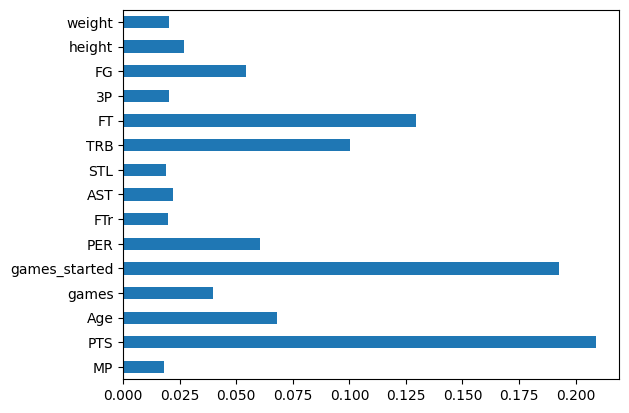

In [116]:
visualize_features(nba, xgb_r)



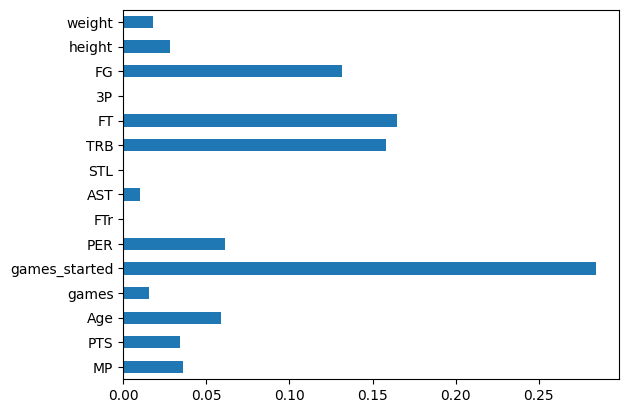

In [117]:
visualize_features(nba, best_random)

# EXTERNAL DATA

In [118]:
nba = common.get_cleaned_external_data()
print(nba.shape)
nba = common.add_log_y_values(nba)

(7672, 33)


In [119]:
print(nba.columns)
X_train, X_test, y_train, y_test = common.split_data(nba)
print(X_train.shape)

Index(['seasonStartYear', 'MP', 'PTS', 'Age', 'games', 'games_started', 'PER',
       'FTr', 'AST', 'STL', 'TRB', 'FT', '3P', 'FG', 'height', 'weight',
       'startYear', 'all_star_total', 'all_star_enc', 'all_nba_enc',
       'all_nba_total', 'draft_pick', 'champion', 'conference_champ', 'mvp',
       'mvp_rank', 'mvp_total', 'player_week_enc', 'player_week_total', 'dpoy',
       'dpoy_rank', 'dpoy_total', 'inflationAdjSalary_log'],
      dtype='object')
(6604, 31)


In [120]:
# Without hyperparameter tuning
xgb_r = run_xg_boost(X_train, X_test, y_train, y_test)

MSE:  0.8193956194863028
r2_socre:  0.48124072670971374
RMSE:  0.9052047389879831
MAE: 0.6599397988914238


In [121]:
# With hyperparameter tuning
best_random = run_randomized_xg_boost(X_train, X_test, y_train, y_test)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[15:00:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[15:00:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[15:00:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[CV] END booster=gblinear, colsample_bytree=0.9, eta=0.5, eval_metric=rmse, gamma=0.4, max_depth=4, min_child_weight=4, n_estimators=500, objective=reg:squarederror, subsample=0.6; total time=   0.3s
[CV] 

[autoreload of common failed: Traceback (most recent call last):
  File "/Users/samkorman/Library/Python/3.11/lib/python/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/Users/samkorman/Library/Python/3.11/lib/python/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.2_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/samkorman/src/eec

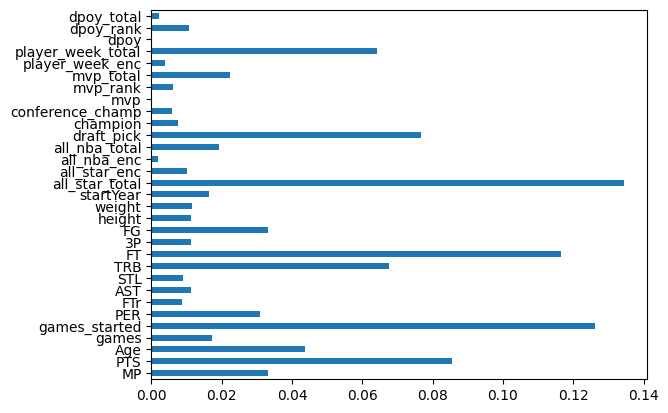

In [122]:
visualize_features(nba, xgb_r)

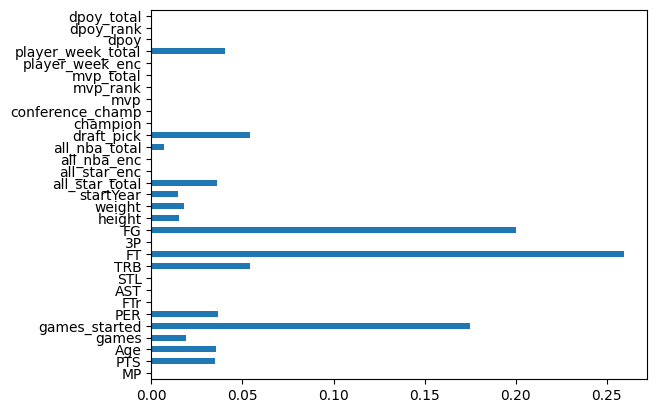

In [123]:
visualize_features(nba, best_random)